In [2]:
import trimesh
from trimesh import registration
import numpy as np

In [3]:
car_model = 'models/cut_out_car_mesh_centered_rotated_scaled_moved.ply'
car = trimesh.load(car_model)
car.show()

In [3]:
plane_model = 'models/low_poly_plane_2.glb'
plane = trimesh.load(plane_model)
# geometries = list(plane.geometry.values())
# plane = trimesh.util.concatenate(geometries)
# plane.visual = plane.visual.to_color()
plane.show()

In [28]:
trimesh.Scene([car, plane]).show()

In [36]:
# car_convex_hull = car.convex_hull
# with open('models/car_export_convex_hull.obj', 'w') as f:
#     f.write(car_convex_hull.export(file_type='obj'))
# with open('models/car_export.obj', 'w') as f:
#     f.write(car.export(file_type='obj'))
# with open('models/plane_export.obj', 'w') as f:
#     f.write(plane.export(file_type='obj'))

In [95]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
# %matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [96]:
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [97]:
from celluloid import Camera

In [98]:
trg_obj = os.path.join('models/plane_export.obj')
verts, faces_idx, _ = load_obj(trg_obj)
faces = faces_idx.verts_idx
verts = verts.to(device)
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

trg_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [94]:
src_obj = os.path.join('models/car_export_convex_hull.obj')
verts, faces_idx, _ = load_obj(src_obj)
faces = faces_idx.verts_idx
verts = verts.to(device)
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

src_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/opt/conda/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [99]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a directional light in the scene. 
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

# Select the viewpoint using spherical angles  
distance = 150   # distance from camera to the object`
elevation = 15.0   # angle of elevation in degrees
azimuth = 35.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-10.0,0.0,10.0),))

In [100]:
# Render the bunny providing the values of R and T. 
image_plane = phong_renderer(meshes_world=trg_mesh, R=R, T=T)
image_car = phong_renderer(meshes_world=src_mesh, R=R, T=T)

image_car = image_car.cpu().numpy()
image_plane = image_plane.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


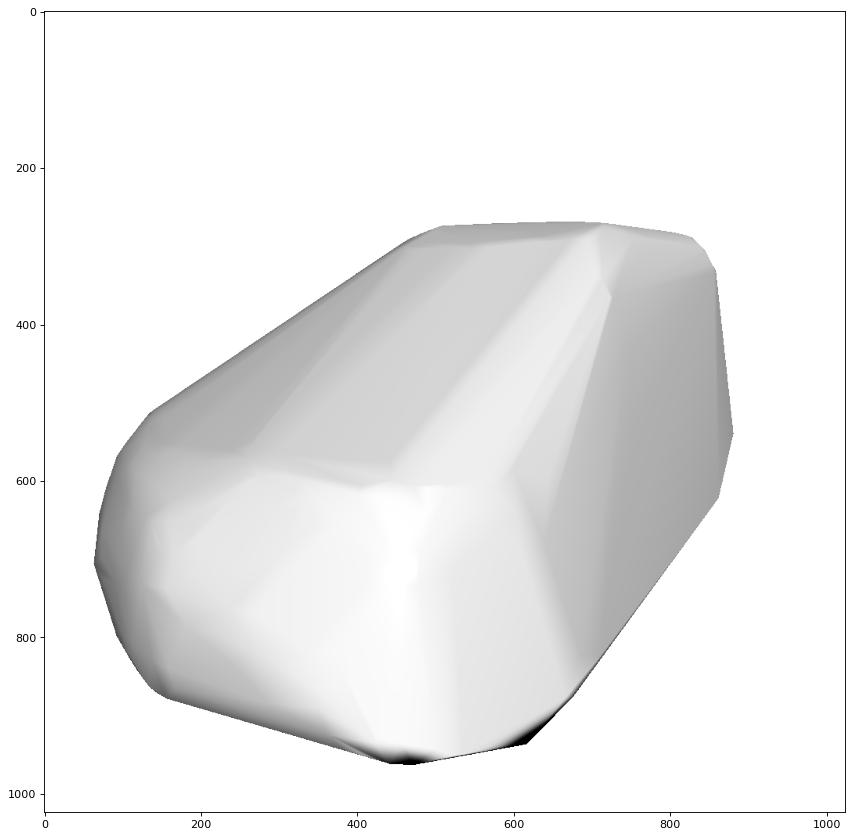

In [101]:
# Source mesh of car
plt.figure(figsize=(13, 13))
plt.imshow(image_car.squeeze())
plt.grid(False)

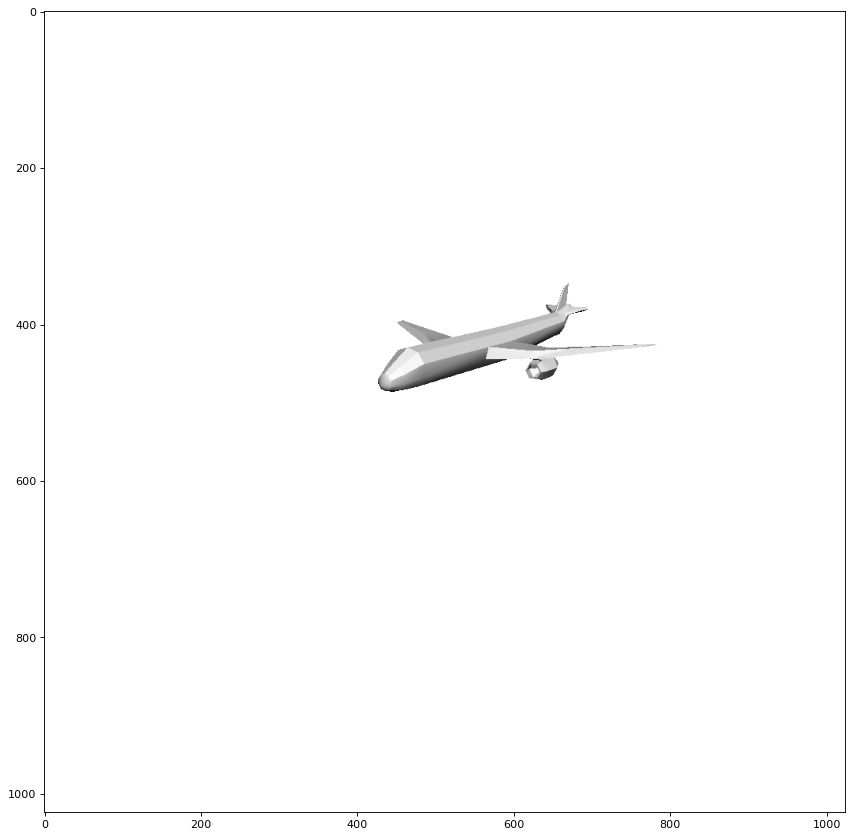

In [102]:
# Target mesh of plane
plt.figure(figsize=(13, 13))
plt.imshow(image_plane.squeeze())
plt.grid(False)

  0%|          | 0/2000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

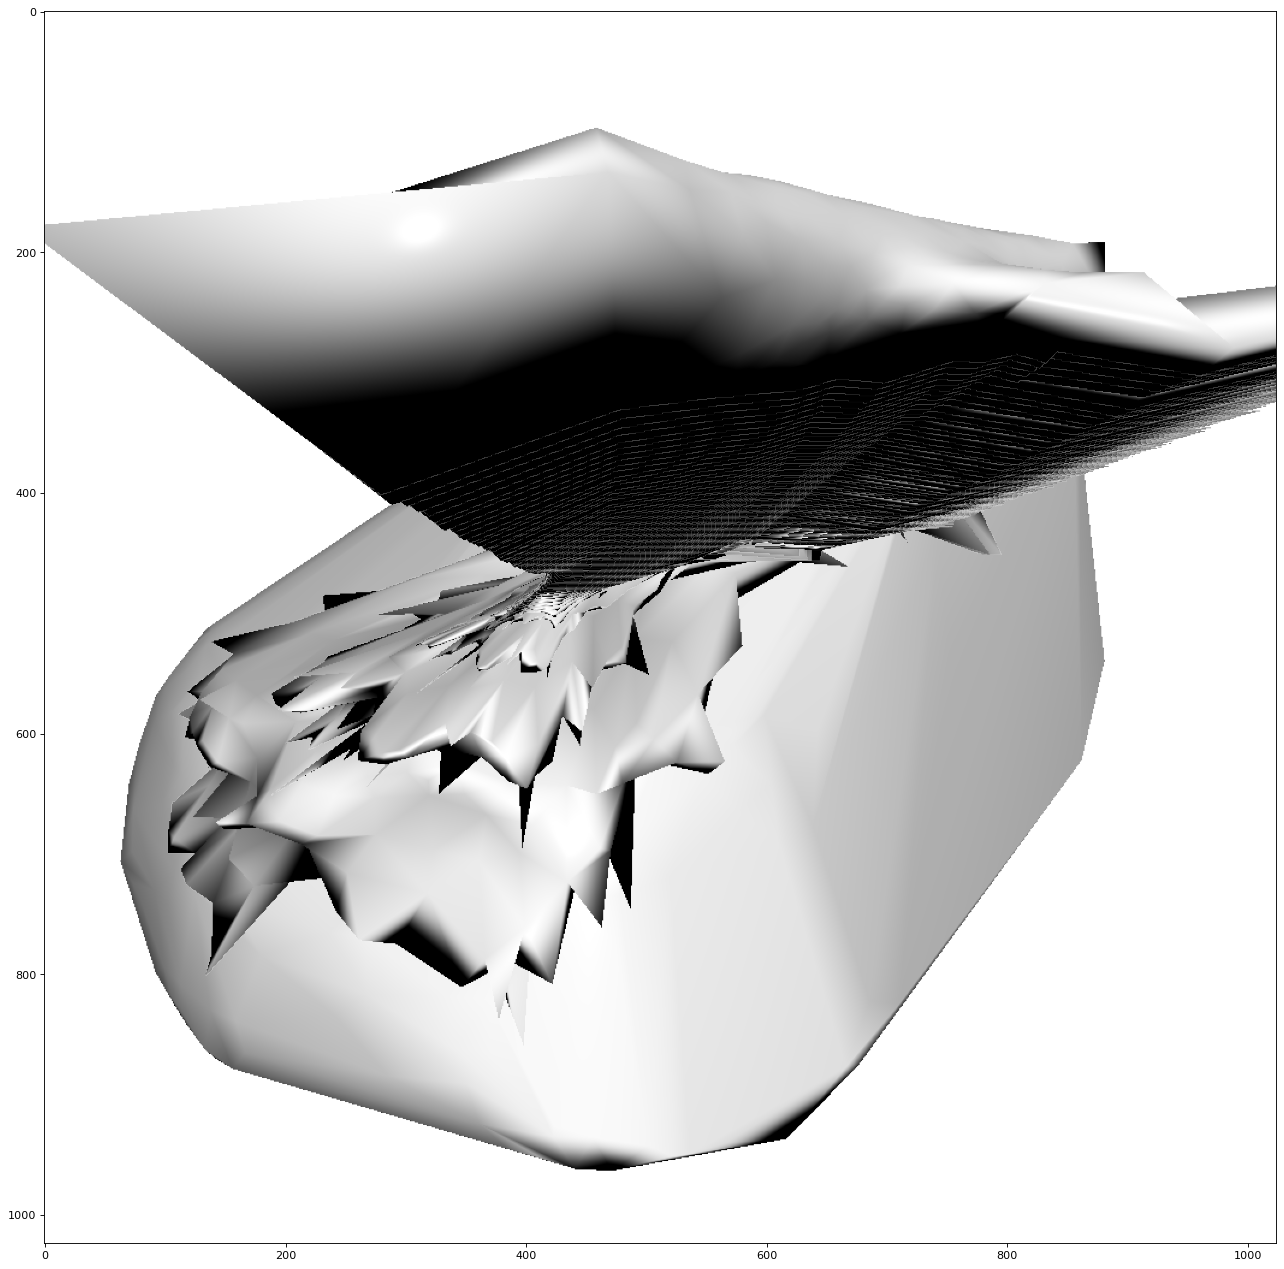

In [107]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

%matplotlib widget

# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 25
loop = tqdm(range(Niter))

distance_start, distance_end = 150, 50

distance_loss = (distance_start - distance_end)/(Niter/plot_period)

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline
fig = plt.figure(figsize=(20, 20))
camera = Camera(fig)


for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0 or i==0:
        R, T = look_at_view_transform(distance_start, elevation, azimuth, device=device,at=((-10.0,0.0,10.0),))
        image_cybertruck = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_cybertruck = image_cybertruck.detach().cpu().numpy()
        
        plt.imshow(image_cybertruck.squeeze())
        plt.grid(False)
        camera.snap()
        distance_start -= distance_loss
        
    # Optimization step
    loss.backward()
    optimizer.step()

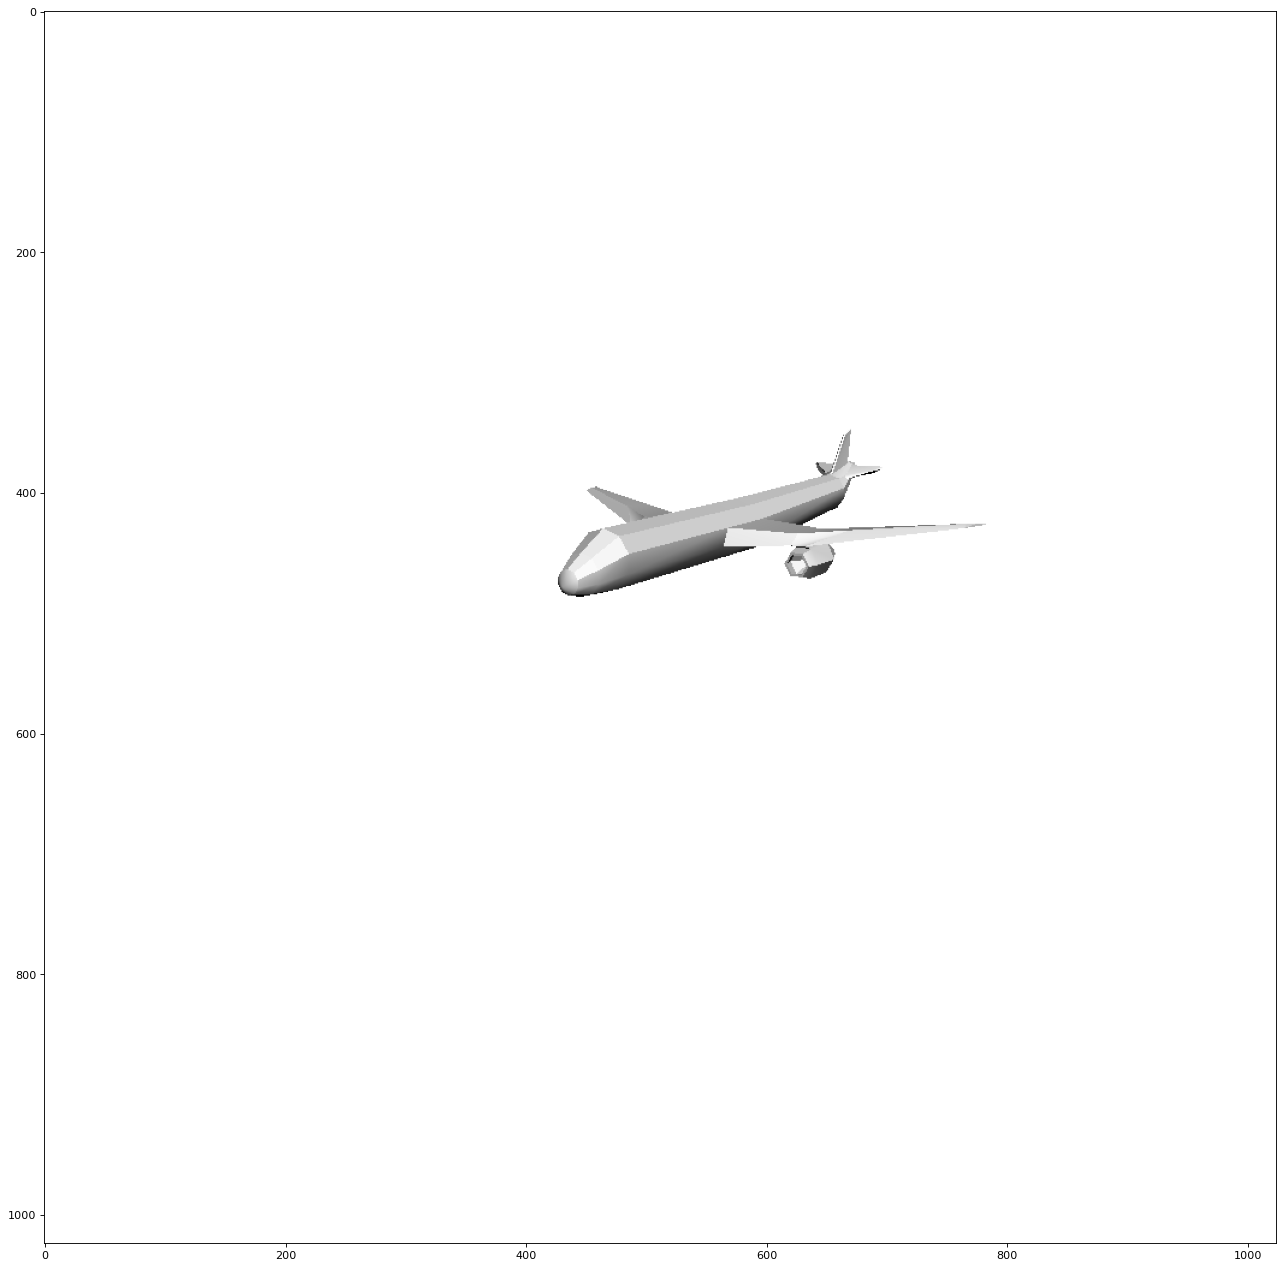

In [104]:
# Final image of plane
plt.figure(figsize=(20, 20))
plt.imshow(image_plane.squeeze())
plt.grid(False)

In [108]:
animation = camera.animate()
animation.save('car_into_plane_convex_hull.gif')

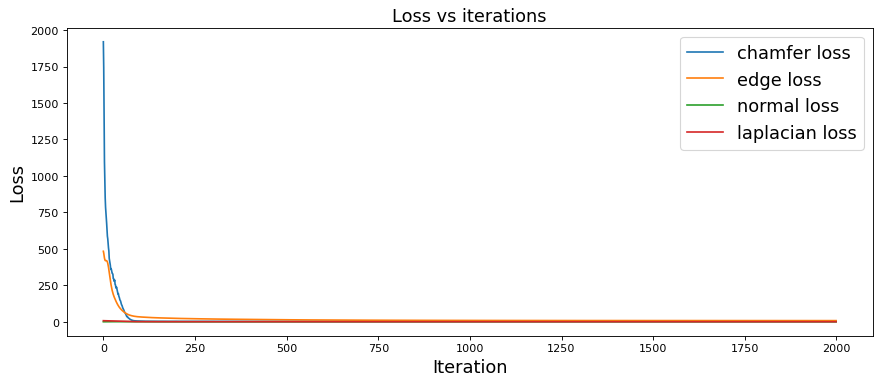

In [109]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");